In [238]:
from linear_adapter import *
from kalman import *
import torch.optim as optim
import numpy as np

In [239]:
# Simulation time
T = 10
dt = 0.01
t_space = np.arange(0, T, dt)

# Noise Parameters
var_x = 0.1
var_z = 0.2
var_y = 0.15

# Define and Simulate System Dynamics
A = np.array([[0, 1, 0], [-1, 0, 0], [0, 0, 0.01]])
H = np.array([3.0, 0.0, 0.5]).reshape((1, 3))
Q = np.diag([var_x, var_x, var_z])
R = np.array([[var_y]])

initial_state = np.array([0, 0, 0]).reshape((1, 3))
initial_covariance = np.diag([0.01, 0.25, 0.01])
state_vec = dynamics(initial_state, t_space, A, dt, var_x, var_z)

x = state_vec[:, 0]
v = state_vec[:, 1]
z = state_vec[:, 2]

# Get Observations
y = observations(H, state_vec, var_y)

# Run Filter
state_hat = kalman_filter(A, H, Q, R, initial_state, initial_covariance, y)
x_hat = state_hat[:, 0]
v_hat = state_hat[:, 1]
z_hat = state_hat[:, 2]

In [240]:
def create_sequences(data, window_size):
    sequences = []
    targets = []
    for i in range(len(data) - window_size):
        seq = data[i:i + window_size]
        target = data[i + window_size]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

In [241]:
window_size = 1

x_sequences, x_targets = create_sequences(x, window_size)
obs_sequences, obs_targets = create_sequences(y, window_size)

# Train/Test Split
split_idx = int(0.7 * len(x_sequences))
x_train = torch.tensor(x_targets[:split_idx])
x_test = torch.tensor(x_targets[split_idx:])
obs_train = torch.tensor(x_sequences[:split_idx])
obs_test = torch.tensor(x_sequences[split_idx:])

# Define Adapting Network
input_dim = window_size
hidden_layers = [2]
output_dim = 1

learning_rate = 0.001
num_epochs = 20000

In [242]:
print(x_train[0:10])
obs_train[0:10]

tensor([-0.0284, -0.1652, -0.1113, -0.0975, -0.0156,  0.1329,  0.1256,  0.0062,
        -0.0087, -0.2241])


tensor([[ 0.0000],
        [-0.0284],
        [-0.1652],
        [-0.1113],
        [-0.0975],
        [-0.0156],
        [ 0.1329],
        [ 0.1256],
        [ 0.0062],
        [-0.0087]])

In [243]:
linear_model = AdaptingMLP(input_dim, hidden_layers, output_dim)
ff_model = linearNN(input_dim, hidden_layers, output_dim)

criterion = nn.MSELoss()
optimizer1 = optim.Adam(linear_model.parameters(), lr=learning_rate)
optimizer2 = optim.Adam(ff_model.parameters(), lr=learning_rate)

#Training loop
linear_model.train()
for epoch in range(num_epochs):
### Adaptive Network
    output1 = linear_model(obs_train)
    loss1 = criterion(output1.squeeze(), x_train)
    
    optimizer1.zero_grad()
    loss1.backward()
    optimizer1.step()

### Linear FF Network
    output2 = ff_model(obs_train)
    loss2 = criterion(output2.squeeze(), x_train)
    
    optimizer2.zero_grad()
    loss2.backward()
    optimizer2.step()

    if (epoch + 1) % 1000 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Adp. Training Loss: {loss1.item():.4f}, FF Training Loss: {loss2.item():4f}')
linear_model.eval()
linear_model.reset_hidden_states()
predicted_output = linear_model(obs_test)
test_loss = criterion(predicted_output.squeeze(), x_test)
print(f'Test Loss: {test_loss.item():.4f}')

linear_model.reset_hidden_states()

x_seq = torch.tensor(x_sequences)
linear_model_rollout = linear_model(x_seq)
ff_model_rollout = ff_model(x_seq)

Epoch [1000/20000], Adp. Training Loss: 0.0563, FF Training Loss: 0.010328
Epoch [2000/20000], Adp. Training Loss: 0.0103, FF Training Loss: 0.010327
Epoch [3000/20000], Adp. Training Loss: 0.0103, FF Training Loss: 0.010327
Epoch [4000/20000], Adp. Training Loss: 0.0103, FF Training Loss: 0.010327
Epoch [5000/20000], Adp. Training Loss: 0.0103, FF Training Loss: 0.010327
Epoch [6000/20000], Adp. Training Loss: 0.0103, FF Training Loss: 0.010327
Epoch [7000/20000], Adp. Training Loss: 0.0103, FF Training Loss: 0.010327
Epoch [8000/20000], Adp. Training Loss: 0.0103, FF Training Loss: 0.010327
Epoch [9000/20000], Adp. Training Loss: 0.0103, FF Training Loss: 0.010327
Epoch [10000/20000], Adp. Training Loss: 0.0103, FF Training Loss: 0.010327
Epoch [11000/20000], Adp. Training Loss: 0.0103, FF Training Loss: 0.010327
Epoch [12000/20000], Adp. Training Loss: 0.0103, FF Training Loss: 0.010327
Epoch [13000/20000], Adp. Training Loss: 0.0103, FF Training Loss: 0.010327
Epoch [14000/20000], 

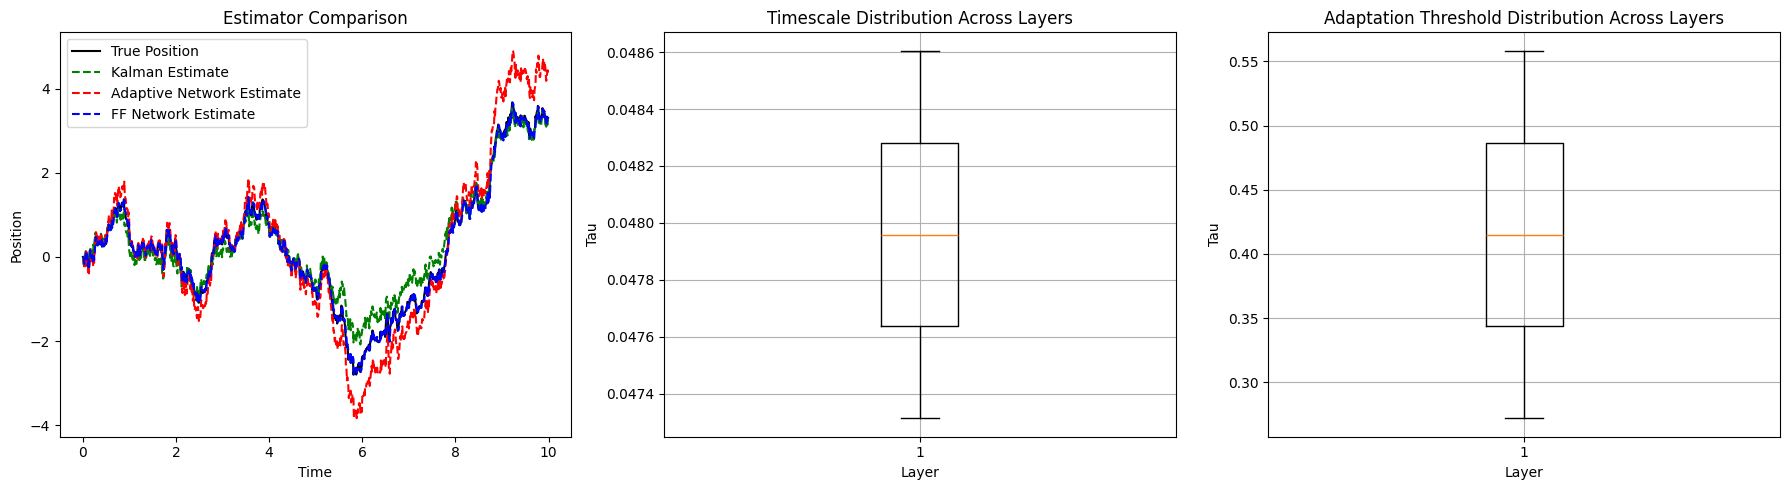

[array([0.04860485, 0.0473128 ])] [array([0.27200612, 0.55826392])]


In [262]:
fig = plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
# Plot results
plt.plot(t_space, x, 'k', label='True Position')
#plt.plot(t_space, z, '-r', label='Nuisance Variable')
#plt.plot(t_space, y, 'm', label='Observations')
plt.plot(t_space, x_hat, 'g', label = 'Kalman Estimate ', linestyle='--')
plt.plot(t_space[window_size:], linear_model_rollout.detach().numpy(), 'r', label = 'Adaptive Network Estimate', linestyle='--')
plt.plot(t_space[window_size:], ff_model_rollout.detach().numpy(), 'b', label = 'FF Network Estimate', linestyle='--')

#plt.ylim([-3, 3])
plt.xlabel('Time')
plt.ylabel('Position')
plt.title('Estimator Comparison')
plt.legend()


all_tau = linear_model.get_all_tau()
all_F = linear_model.get_all_F()

data_for_boxplot = [list(v) for v in all_tau]

# Plotting
#plt.figure(figsize=(10, 6))
plt.subplot(1, 3, 2)
#
plt.boxplot(data_for_boxplot, positions=np.arange(1, len(all_tau) + 1))
# Customize the plot
plt.xlabel('Layer')
plt.ylabel('Tau')
plt.title('Timescale Distribution Across Layers')
plt.xticks(np.arange(1, len(all_tau) + 1), labels=np.arange(1, len(all_tau) + 1))  # Set x-axis ticks and labels
plt.grid(True)


data_for_boxplot = [list(v) for v in all_F]
# Plotting
#plt.figure(figsize=(10, 6))

plt.subplot(1, 3, 3)
plt.boxplot(data_for_boxplot, positions=np.arange(1, len(all_F) + 1))

# Customize the plot
plt.xlabel('Layer')
plt.ylabel('Tau')
plt.title('Adaptation Threshold Distribution Across Layers')
plt.xticks(np.arange(1, len(all_F) + 1), labels=np.arange(1, len(all_F) + 1))  # Set x-axis ticks and labels
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()

print(all_tau, all_F)

In [263]:
for name, param in ff_model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

layers.0.weight tensor([[0.9762],
        [0.7084]])
layers.0.bias tensor([-0.4589, -0.0285])
output_layer.weight tensor([[0.5475, 0.6509]])
output_layer.bias tensor([0.2668])


In [246]:
time = np.linspace(0, 15, 1000)  # Time from 0 to 15 with 1000 points
dt = time[1] - time[0]  # Time step
step_time = 5  # Time when the step stimulus occurs
stimulus_duration = 3  # Duration of the step stimulus
step_value = 1.0  # Value of the step stimulus
s = np.where((time >= step_time) & (time <= step_time + stimulus_duration), step_value, 0)  # Step stimulus


In [247]:

all_tau = linear_model.get_all_tau()
all_F = linear_model.get_all_F()

print(all_tau, all_F)

[array([0.04860485, 0.0473128 ])] [array([0.27200612, 0.55826392])]


0.048604850470228514 0.2720061223984163
0.047312799891557594 0.5582639246607138


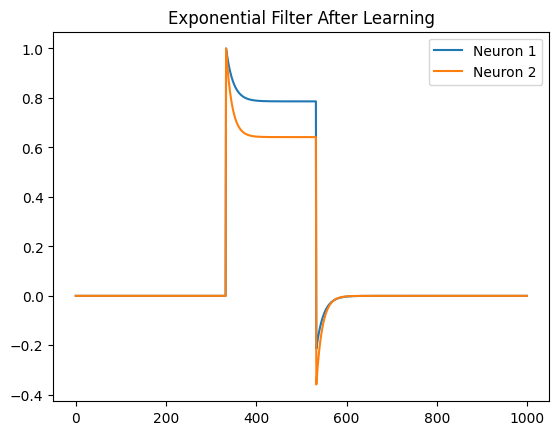

In [248]:
arr=[]
for i in range(len(hidden_layers) + 1):
    print(np.abs(all_tau[0][i]), all_F[0][i])
    y = np.zeros_like(s)
    a = np.zeros_like(s)
    for t in range(1, len(time)):

        a[t] = a[t-1] + np.abs(all_tau[0][i]) * (-a[t-1] + np.abs(all_F[0][i])*y[t-1])
        y[t] = s[t]-a[t]
    arr.append(y)
plt.plot(arr[0], label='Neuron 1')
plt.plot(arr[1], label = 'Neuron 2')
plt.title('Exponential Filter After Learning')
plt.legend()
plt.show()
